# Adaptive PDE discretizations on Cartesian grids, Taichi implementations

## Volume : Proximal methods

## Part : Ballistic Benamou-Brenier formulations

## Chapter : Burgers' equation with optional viscosity

$\DeclareMathOperator*\argmin{argmin}\DeclareMathOperator\prox{prox}$

<!--- We implement Burgers' one dimensional PDE with 
- optional viscosity
- a r.h.s (?)
- all four combinations of staggered in time and space in the perspective functions.
---> 
**Problem formulation.**
The original problem reads
$$
    \partial_t u + \frac 1 2 \partial_x u^2 = \nu \partial_{xx} u + f.
$$
Following the ballistic Benamou-Brenier (BBB) principle (i.e. minimizing $\int_{t,x} u^2$ among weak solutions, and interverting inf-sup) we arrive at
$$
\inf_{\phi(T)=0} \int_{t,x} \frac{(\partial_t \phi + \nu \partial_{xx} \phi)^2} {1-\partial_x \phi} - \int_{t,x} f\phi + \int_x u_0 \phi(0).
$$
This can be reformulated as 
\begin{align*}
&\inf_{m,\rho} \int_{t,x} \frac {(m-\nu \partial_x \rho)^2}{\rho} + F m &
\partial_t \rho + \partial_x m = 0, \quad \rho(T)=1
\end{align*}
where 
$$
    F(t,x) =  \int_0^t f(s,x) ds - u_0(x)
$$


**Discretization.**
Denoting by $\tau$ and $h$ the *half* timestep and *half* gridscale, we optimize the energy:
$$
	E_{\tau h}(m,\rho) := 4 \tau h\sum_{\substack{t \in T'_\tau\\x\in T_h}} 
	\Big(\frac 1 4 \sum_{\substack{\sigma_t =\pm\\ \sigma_x=\pm}} 
	\frac{\big(m(t,x) - \nu \partial_h \rho(t+\sigma_t \tau, x)\big)^2}
	{2\rho(t+\sigma_t \tau ,x+\sigma_x h)} + m(t,x) F(t,x)\Big).
$$
subject to $\rho(T)=1$, and the linear constraint
$$
    \partial_\tau \rho + \partial_h m = 0.
$$
The proximal method requires some duplication of variables, namely an extension by oddness and evenness
\begin{align*}
\rho(t) &= \rho(-t), t \in T, &
m(t)&=-m(-t),t \in T',
\end{align*}
in such way that we can fix $\sigma_t = +$ in the above. 
In the above expressions, the finite differences $\partial_\tau$ and $\partial_h$ are symmetric, and $\rho$ and $m$ are defined on suitably staggered grids. 

<!---
Note that $w_\sigma(t) = -w_\sigma(-t)$.

In addition we let for $\sigma=\pm$
$$
    w_\sigma = m - \nu \partial_h \rho(t+\tau),
$$
(this expression purposedly does not depend on $\sigma$).
In the case where $\nu = 0$, one of these can be discarded. 

--->


**Unknowns centering.**
- $\phi$ : centered in time and space
- $\rho = 1-\partial_h \phi$ : centered in time, staggered in space
- $m = m_0 = m_1 = \partial_\tau \phi$ : staggered in time, centered in space.
- $a=a_0=a_1 = \nu \partial_{-h} \rho$ : centered in time and space.
- $u_0$ : centered in space (no time). 

## 0. Importing the required libraries

In [10]:
import taichi as ti
#import torch
import numpy as np
import scipy.fft
from copy import deepcopy
from matplotlib import pyplot as plt

cmul = ti.math.cmul; cconj = ti.math.cconj
π = np.pi

In [11]:
agd_path = "/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations"; agdt_path = "/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AGDT/AdaptiveGridDiscretizations_Taichi"
import sys; sys.path.insert(0,agd_path); sys.path.insert(0,agdt_path)

from agd import AutomaticDifferentiation as ad
from agd import LinearParallel as lp
norm = ad.Optimization.norm
norminf = ad.Optimization.norm_infinity
from agd.Plotting import savefig
from agd import FiniteDifferences as fd

from agdt.Proximal import Proj,Misc,Prox
from agdt.Proximal.Misc import ticplx,cnorm2
#from BBB.misc import dtypeConversions,ticplx,cnorm2
#from BBB.proj import mk_proj_even,mk_proj_odd

### 0.1 Additional configuration

In [12]:
ti.init(arch=ti.cpu,default_fp=ti.f64) # Default data types are f32 et i32

[Taichi] Starting on arch=arm64


In [13]:
#savefig.dirName = "/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/Papers/BBBPorous/Burgers/Illustrations/Burgers"

## 1. Orthogonal projection

We have the usual parity constraints : $m(-t)=-m(t)$, $\rho(-t)=\rho(t)$, $a(-t)=a(t)$, and in addition
\begin{align*}
    \partial_\tau \rho + \partial_h m &= 0, &
    a &= -\nu\partial_{-h} \rho.
\end{align*}
In order to compute the proximal operator in (almost) closed form, we need to duplicate the variables $m$ and $a$.

Note that the centered finite difference operator, on suitably staggered grids, satisfies $\partial_h = \partial_{-h}$. 
Of course the actual implementation uses standard arrays with integer indices, hence the centered finite differences are replaces with suitable upwind or downwind finite differences.

<!---
    def proj(m0,m1,ρ,a0,a1,inplace=True):
        if not inplace: m = deepcopy(m); ρ=deepcopy(ρ); a=deepcopy(a)
        assert m.shape[-1]==2 and a.shape[-1]==2; m_ = np.sum(m,axis=-1)/2; a_ = np.sum(a,axis=-1)/2 # Projection onto m=m' and a=a'
        proj_odd(m_); proj_even(ρ); proj_even(a_)
        Fm = fft.fftn(m_); Fρ = fft.fftn(ρ); Fa = fft.fftn(a_)
        proj_Fourier(ticplx(Fm),ticplx(Fρ),ticplx(Fa),
                    ticplx(FDt),ticplx(FDx),ticplx(νFDxx))
        Fa[0,0]=0 # zero frequency in both time and space needs separate handling 
        m[...,0] = fft.ifftn(Fm).real; ρ[:] = fft.ifftn(Fρ).real; a[...,0] = fft.ifftn(Fa).real; m[...,1]=m[...,0]; a[...,1]=a[...,0]
        return m,ρ,a

    def proj1(m,ρ,a,inplace=True):
        if not inplace: m = deepcopy(m); ρ=deepcopy(ρ); a=deepcopy(a)
        proj_odd(m); proj_even(ρ); proj_even(a)
        Fm = fft.fftn(m); Fρ = fft.fftn(ρ); Fa = fft.fftn(a)
        proj_Fourier(ticplx(Fm),ticplx(Fρ),ticplx(Fa),
                    ticplx(FDt),ticplx(FDx),ticplx(νFDxx))
        Fa[0,0]=0 # zero frequency in both time and space needs separate handling 
        m[:] = fft.ifftn(Fm).real; ρ[:] = fft.ifftn(Fρ).real; a[:] = fft.ifftn(Fa).real
        return m,ρ,a
    proj.proj1 = proj1

def cstr_Burgers1(m,ρ,a,dt,dx,ν):
    nT = len(m)//2
    return m[:nT]+m[nT:][::-1], \
    fd.DiffUpwind(ρ,(1,0),dt,padding=None)+fd.DiffUpwind(m,(0,1),dx,padding=None), \
    a + ν*fd.DiffUpwind(ρ,(0,-1),dx,padding=None)
    # a - ν*fd.DiffUpwind(ρ,(0,1),dx,padding=None)

# Without variable duplication
np.random.seed(42)
m,ρ,a = [np.random.rand(*shape)-0.5 for i in range(3)]
proj_lsqr1 = Proj.make_lsqr_proj(cstr_Burgers1,(m,ρ,a),Diag=(2,1,2),Aargs=(dt,dx,ν))
proj_ti = mk_proj_Burgers(dt,dx,ν,ρ)
m_lsqr,ρ_lsqr,a_lsqr = proj_lsqr1(m,ρ,a)
m_ti,ρ_ti,a_ti = proj_ti.proj1(m,ρ,a)

#print(f"{tuple(map(norminf,cstr_Burgers(m_lsqr,ρ_lsqr,a_lsqr,dt,dx,ν)))}")
#print(f"{tuple(map(norminf,cstr_Burgers(m_ti,ρ_ti,a_ti,dt,dx,ν)))}")
for x_lsqr,x_ti in zip((m_lsqr,ρ_lsqr,a_lsqr), (m_ti,ρ_ti,a_ti)):
    assert np.allclose(x_lsqr,x_ti,atol=1e-5)

--->

In [14]:
def mk_proj_Burgers(dt,dx,ρ,ν=None):
    """Build the orthogonal projection onto Dtρ+Dxm=0, a=-ν*Dxρ, m'=m, a'=a, and parity constraints"""
    # Data types and conversions
    np_float_t = Misc.convert_dtype['np'][ρ.dtype]
    float_t = Misc.convert_dtype['ti'][np_float_t]
    cplx = ti.lang.matrix.VectorType(2,float_t) # !! use ti.math.cmul, etc
    π = np_float_t(np.pi) 
    shape=ρ.shape
    proj_even = Proj.mk_proj_even(float_t); proj_odd = Proj.mk_proj_odd(float_t)
    fft = Misc.get_fft_module(ρ)
    
    # Compute the Fourier transform of differential operators
    ξt = np.arange(shape[0],dtype=np_float_t)/shape[0]
    FDt = (np.exp(2j*π*ξt)-1)/dt
    ξx = np.arange(shape[1],dtype=np_float_t)/shape[1]
    FDx = (np.exp(2j*π*ξx)-1)/dx
    νFDxx = ν*(FDx.real**2+FDx.imag**2) if ν is not None else 0*FDx.real

    
    @ti.kernel # Without viscosity
    def proj_ti(        
        Fm:   ti.types.ndarray(dtype=cplx,ndim=2), # t,x
        Fρ:   ti.types.ndarray(dtype=cplx,ndim=2), # t,x
        FDt:  ti.types.ndarray(dtype=cplx,ndim=1), # t
        FDx:  ti.types.ndarray(dtype=cplx,ndim=1)):# x  
        for t,x in Fρ:
            vv = 2*cnorm2(FDt[t])+cnorm2(FDx[x]) # Factor 2 accounts for doubled weight of m 
            if vv>0:
                xv = 2*cmul(cconj(-FDt[t]),Fm[t,x])+cmul(cconj(FDx[x]),Fρ[t,x])
                xv /= vv
                Fm[t,x] = cmul(-FDt[t], xv)
                Fρ[t,x] = cmul(FDx[x],  xv)
    
    @ti.kernel # With viscosity
    def proj_ν_ti(
        Fm:   ti.types.ndarray(dtype=cplx,ndim=2),# t,x
        Fρ:   ti.types.ndarray(dtype=cplx,ndim=2),# t,x
        Fa:   ti.types.ndarray(dtype=cplx,ndim=2),# t,x 
        FDt:  ti.types.ndarray(dtype=cplx,ndim=1),# t
        FDx:  ti.types.ndarray(dtype=cplx,ndim=1),# x 
        νFDxx:ti.types.ndarray(dtype=float_t,ndim=1),# x 
    ):
        for t,x in Fρ:
            vv = 2*cnorm2(FDt[t])+cnorm2(FDx[x])+2*νFDxx[x]**2 # Factor 2 accounts for doubled weight of m and a
            if vv>0:
                xv = 2*cmul(cconj(-FDt[t]),Fm[t,x])+cmul(cconj(FDx[x]),Fρ[t,x])+2*νFDxx[x]*Fa[t,x]
                xv /= vv
                Fm[t,x] = cmul(-FDt[t], xv)
                Fρ[t,x] = cmul(FDx[x],  xv)
                Fa[t,x] = νFDxx[x]*xv

    def proj(m0,m1,ρ,inplace=True):
        if not inplace: m0 = deepcopy(m0); m1=deepcopy(m1); ρ=deepcopy(ρ)
        m = (m0+m1)/2
        proj_odd(m); proj_even(ρ)
        Fm = fft.fftn(m); Fρ = fft.fftn(ρ)
        proj_ti(ticplx(Fm),ticplx(Fρ),ticplx(FDt),ticplx(FDx))
        m0[:] = fft.ifftn(Fm).real; ρ[:] = fft.ifftn(Fρ).real; m1[:]=m0;
        return m0,m1,ρ
        
    def proj_ν(m0,m1,ρ,a0,a1,inplace=True):
        if not inplace: m0 = deepcopy(m0); m1=deepcopy(m1); ρ=deepcopy(ρ); a0=deepcopy(a0); a1=deepcopy(a1)
        m = (m0+m1)/2; a=(a0+a1)/2
        proj_odd(m); proj_even(ρ); proj_even(a)
        Fm = fft.fftn(m); Fρ = fft.fftn(ρ); Fa = fft.fftn(a)
        proj_ν_ti(ticplx(Fm),ticplx(Fρ),ticplx(Fa),ticplx(FDt),ticplx(FDx),νFDxx)
        Fa[0,0]=0 # zero frequency in both time and space needs separate handling 
        m0[:] = fft.ifftn(Fm).real; ρ[:] = fft.ifftn(Fρ).real; a0[:] = fft.ifftn(Fa).real; m1[:]=m0; a1[:]=a0
        return m0,m1,ρ,a0,a1
        
    return proj if ν is None else proj_ν

Let us validate this projection by comparing with an lsqr projection, on random data.

In [15]:
def cstr(m0,m1,ρ,dt,dx):
    """Constraint for the non-viscous Burgers equation"""
    nT = len(m0)//2
    return m0-m1, m0[:nT]+m0[nT:][::-1], \
    fd.DiffUpwind(ρ,(1,0),dt,padding=None)+fd.DiffUpwind(m0,(0,1),dx,padding=None)
    
def cstr_ν(m0,m1,ρ,a0,a1,dt,dx,ν):
    """Constraint for the viscous Burgers equation"""
    nT = len(m0)//2
    return m0-m1, a0-a1, m0[:nT]+m0[nT:][::-1], \
    fd.DiffUpwind(ρ,(1,0),dt,padding=None)+fd.DiffUpwind(m0,(0,1),dx,padding=None), \
    a0 - ν*fd.DiffUpwind(ρ,(0,-1),dx,padding=None)

In [16]:
dt = 0.6; dx = 0.7; shape = (6,7); ν = 0.5
np.random.seed(42)
m0,m1,ρ,a0,a1 = [np.random.rand(*shape)-0.5 for i in range(5)]
# Non-viscous case
proj_ls = Proj.make_lsqr_proj(cstr,(m0,m1,ρ),Aargs=(dt,dx))
proj_ti = mk_proj_Burgers(dt,dx,ρ)
m0_ls,m1_ls,ρ_ls = proj_ls(m0,m1,ρ)
m0_ti,m1_ti,ρ_ti = proj_ti(m0,m1,ρ,inplace=False)
for x_ls,x_ti in zip((m0_ls,m1_ls,ρ_ls), (m0_ti,m1_ti,ρ_ti)):
    print(norminf(x_ls-x_ti)); assert np.allclose(x_ls,x_ti,atol=2e-5)

# Viscous case
proj_ls = Proj.make_lsqr_proj(cstr_ν,(m0,m1,ρ,a0,a1),Aargs=(dt,dx,ν))
proj_ti = mk_proj_Burgers(dt,dx,ρ,ν)
m0_ls,m1_ls,ρ_ls,a0_ls,a1_ls = proj_ls(m0,m1,ρ,a0,a1)
m0_ti,m1_ti,ρ_ti,a0_ti,a1_ti = proj_ti(m0,m1,ρ,a0,a1,inplace=False)
for x_ls,x_ti in zip((m0_ls,m1_ls,ρ_ls,a0_ls,a1_ls), (m0_ti,m1_ti,ρ_ti,a0_ti,a1_ti)):
    print(norminf(x_ls-x_ti)); assert np.allclose(x_ls,x_ti,atol=5e-5)

4.104283406150544e-06
8.965534505619988e-06
6.474660742390725e-06
9.535342528455004e-06
1.4001086975384824e-05
1.7064271384599483e-05
2.7360689704658547e-05
3.7492524183849185e-05


The fields constructed from a potential $\phi$ of course obey the constraints.

<!---
# !! Comparison with earlier implementation.
# !! Does not match because we used finite differences in the other direction for Dtρ
def Fourier_proj_mρ(m0,m1,ρ,dt,dx,verb=1):
    nT = len(ρ)//2; nX = ρ.shape[1]
    ξT = np.arange(2*nT,dtype=ρ.dtype)[:,None]/(2*nT)
    ξX = np.arange(nX,dtype=ρ.dtype)[None,:]/nX
    fft = Misc.get_fft_module(ρ)

    m = (m0+m1)/2 # Average m0 and m1, to project onto the equality constraint
    Ftρ = fft.fft(ρ,axis=0) # Fourier wrt time variable
    Ftm = fft.fft(m,axis=0)*np.exp(-1j*ξT*π) # Take half period time shift into account
    if verb>0: print("Should be zero if ρ is already symmetric : ", norminf(Ftρ.imag)) 
    if verb>0: print("Should be zero if m is already anti-symmetric : ",norminf(Ftm.real))

    Ftρ = Ftρ.real # Project onto symmetric functions 
    Ftm = Ftm.imag # * 1j # Project onto antisymmetric functions, omitting 1j

    Fρ = fft.fft(Ftρ,axis=1)
    Fm = fft.fft(Ftm,axis=1) 
    Fm *= 1j * np.exp(-1j*ξX*π) # Take half period space shift into account, put back 1j

    # Fourier transforms of the finite difference operators
    FDt = 2*np.sin(π*ξT)/dt
    FDx = 2*np.sin(π*ξX)/dx
    Fsum = FDt*Fρ+FDx*Fm
    if verb>0: print("Should be zero if Dtρ+Δm = 0 is already satisfied : ",norminf(Fsum)) 
    # Important : since the variable m is originally duplicated the norm to consider is here ρ^2+2m^2, hence the 1/2 factor
    F2 = FDt**2+FDx**2/2
    F2[(0,)*ρ.ndim]=1 # Avoid zero divide for null frequency
    Fsum/=F2
    
    Fρ -= Fsum*FDt
    Fm -= Fsum*FDx/2

    ρ_new = fft.ifftn(Fρ)
    m_new = fft.ifftn(Fm * np.exp(1j*ξT*π) * np.exp(1j*ξX*π))
    if verb>0: print("Should be zero if ρ and m already satisfy the constraints :",norminf(ρ_new-ρ),",",norminf(m_new-m))
    if verb>0: print("Should be zero for real variables :",norminf(ρ_new.imag),",",norminf(m_new.imag))

    return m_new.real,m_new.real,ρ_new.real # Re-duplicate m

m0_f,m1_f,ρ_f = Fourier_proj_mρ(m0,m1,ρ,dt,dx)
proj_ti = mk_proj_Burgers(dt,dx,ρ)
m0_ti,m1_ti,ρ_ti = proj_ti(m0,m1,ρ,inplace=False)
for x_f,x_ti in zip((m0_f,m1_f,ρ_f), (m0_ti,m1_ti,ρ_ti)):
    assert np.allclose(x_ls,x_ti,atol=3e-5)
--->

## 2. Proximal operator

Burgers energy functional reads 
$$
    \int \frac{(m-\nu\partial_x\rho)^2}{2\rho} - F m.
$$ 

This is discretized as 
$$
    \frac 1 4 \sum_{\sigma_x=\pm} \frac{(sign(t) m(t,x)-a(t-\tau,x))^2}{2\rho(t-\tau,x+\sigma_x h)} - F(t,x) m(t,x),
$$
with $a = \nu \partial_h \rho$, and the usual constraint $\rho(T)=1$.
The scheme is second order in time thanks to the periodization, which amounts to a $\sigma_t=\pm$ symmetrization.

**Orthogonal splitting of a proximal operator.**
Let $P_0,P_1$ be matrices such that 
$$
    P_0^\top P_0 + P_1^\top P_1 = I.
$$
Let $f_0,f_1$ be (convex s.c.i proper) functions, and $f := f_0 P_0 + f_1 P_1$. Then 
\begin{align*}
    \prox_{\tau f}(x) &= \argmin_{x} \frac 1 2 \|x-y\|^2+\tau f(y)\\
    &=P_0^\top \argmin_{y_0} \Big(\frac 1 2 \|P_0 x-y_0\|^2 + \tau f_0(y_0)\Big)
    {+} P_1^\top \argmin_{y_1} \Big(\frac 1 2 \|P_1 x-y_1\|^2 + \tau f_1(y_1)\Big)\\
    &= P_0^\top \prox_{\tau f_0}(P_0 x) + P_1^\top \prox_{\tau f_1}(P_1 x).
\end{align*}

**Application to the perspective function.**
We consider $f_0 = P$ the perspective function, $f_1 = 0$ the null function, and 
\begin{align*}
    P_0(m,\rho,a) &:= (\frac{m+a}{\sqrt 2}, \rho),&
    P_1(m,\rho,a) &= \frac {a-m}{\sqrt 2}.
\end{align*}
Then $f := f_0 P_0 + f_1 P_1 = P(m+a,\rho)/2$, and thus
\begin{align*}
    \prox_f(m,\rho,a) &= (\frac{m'-a'}{\sqrt 2}, \rho', \frac{m'+a'}{\sqrt 2}),\\
    (m',\rho') &= \prox_{\tau P} (\frac{m+a}{\sqrt 2}, \rho), &
    a' = \frac{a-m}{\sqrt 2}.
\end{align*}

In [17]:
def mk_prox_Burgers(F,ν=None):
    Nt2,Nx = F.shape
    Nt = Nt2//2
    np_float_t = Misc.convert_dtype['np'][F.dtype]
    float_t = Misc.convert_dtype['ti'][np_float_t]
    prox_perspective = Prox.mk_prox_perspective_vec(2,float_t) # Two-dimensional vector version
    vec2 = ti.lang.matrix.VectorType(2,float_t)
    is2 = np_float_t(1/np.sqrt(2))
    field = ti.types.ndarray(dtype=float_t,ndim=2) #t,x
    
    @ti.kernel # Without viscosity
    def prox_ti(τ:float_t,m0:field,m1:field,ρ:field,F:field): #t,x
        for t,x0 in ti.ndrange(Nt2,Nx):
            x1 = (x0+1)%Nx 
            M0 = m0[t,x0]+τ*F[t,x0]
            M1 = m1[t,x1]+τ*F[t,x1]
            if t==nT: # Prox of quadratic
                ρ[t,x0] = 1
                m0[t,x0] = M0/(1+τ)
                m1[t,x1] = M1/(1+τ)
            else: # Prox of perspective
                ρ[t,x0],v = prox_perspective(τ,ρ[t,x0],vec2(M0,M1))
                m0[t,x0]=v[0]
                m1[t,x1]=v[1]

    @ti.kernel
    def prox_ν_ti(τ:float_t,m0:field,m1:field,ρ:field,a0:field,a1:field,F:field): #t,x
        for t,x0 in ti.ndrange(Nt2,Nx):
            ϵ = 1-2*(t>=Nt)
            x1 = (x0+1)%Nx
            M0 = ϵ*(m0[t,x0]+τ*F[t,x0])
            M1 = ϵ*(m1[t,x1]+τ*F[t,x1])
            A0 = a0[t,x0]; A1 = a1[t,x1]
            
            B0 = is2*(M0+A0); C0 = is2*(M0-A0)
            B1 = is2*(M1+A1); C1 = is2*(M1-A1)
            V0:float_t = np.nan; V1:float_t = np.nan # Dummy initialization
            if t==nT: # Prox of quadratic
                ρ[t,x0] = 1
                V0 = B0/(1+2*τ)
                V1 = B1/(1+2*τ)
            else: # Prox of perspective
                ρ[t,x0],v = prox_perspective(2*τ,ρ[t,x0],vec2(B0,B1))
                V0 = v[0]; V1=v[1]
            m0[t,x0] = ϵ*is2*(V0+C0)
            m1[t,x1] = ϵ*is2*(V1+C1)
            a0[t,x0] =   is2*(V0-C0)
            a1[t,x1] =   is2*(V1-C1)
    
    def prox(m0,m1,ρ,τ,inplace=True):
        """Inplace proximal operator for Burgers, without viscosity.
        - m0,m1 : centered in space, staggered in time.
        - ρ : staggered in space, centered in time.
        """
        if not inplace: m0=deepcopy(m0); m1=deepcopy(m1); ρ=deepcopy(ρ)
        prox_ti(τ,m0,m1,ρ,F)
        return m0,m1,ρ
    def prox_ν(m0,m1,ρ,a0,a1,τ,inplace=True):
        """Inplace proximal operator for Burgers, with viscosity
        - a0,a1 : centered in space and time
        """
        if not inplace: m0=deepcopy(m0); m1=deepcopy(m1); ρ=deepcopy(ρ); a0=deepcopy(a0); a1=deepcopy(a1)
        prox_ν_ti(τ,m0,m1,ρ,a0,a1,F)
        return m0,m1,ρ,a0,a1
        
    return prox if ν is None else prox_ν

Now let us check this proximal operator implementation using autodiff and an independent implementation.

Note : roll($\rho,k$) corresponds to $\rho(\cdot-k)$.


<!---
def prox_ρma(τ,ρ,m0,m1,a0,a1,u0):
    """Proximal operator of the objective function m^2/(2ρ)-u0 m, with constraint ρ(T)=1."""
    nT = len(ρ)//2
    ϵ = sign_m(len(m0))[:,None]
    xp = Misc.get_array_module(u0)
    x = xp.asarray([ρ,m0+τ*ϵ*u0,np.roll(m1+τ*ϵ*u0,-1,axis=1)]) 
    xP = prox_perspective(τ,x)
    ρP = xP[0]; m0P = xP[1]; m1P = np.roll(xP[2],1,axis=1)
    ρP[nT] = 1 # Enforce the constraint, and use explicit prox for the quadratic objective
    m0P[nT] = (m0[nT]-τ*u0)/(1+τ) # Caution : anti-symmetric extension of m
    m1P[nT] = (m1[nT]-τ*u0)/(1+τ)
    return ρP,m0P,m1P
--->

In [18]:
def sign_m(N): 
    """Signs corresponding to the anti-symmetric extension of m"""
    return np.concatenate((np.ones(N//2),-np.ones(N//2)))
def _Energy_mρ(m,ρ,u0):
    return 0.5*np.sum(m**2/ρ) - np.sum(u0*m)
def Energy_mρ(m0,m1,ρ,u0):
    """Caution : modified centering. We now shift ρ, which is staggered in space."""
    ϵ = sign_m(len(m0))[:,None]
    return _Energy_mρ(ϵ*m0,ρ,u0) + _Energy_mρ(ϵ*m1,np.roll(ρ,1,axis=1),u0)
def Energy_mρa(m0,m1,ρ,a0,a1,u0):
    ϵ = sign_m(len(m0))[:,None]
    return 0.5*np.sum((ϵ*m0+a0)**2/ρ + (ϵ*m1+a1)**2/np.roll(ρ,1,axis=1)) - np.sum(u0*ϵ*(m0+m1))

from agd.ExportedCode.Notebooks_Div.PorousMinimization import prox_perspective    
def prox_mρ(τ,m0,m1,ρ,u0):
    """Proximal operator of the objective function m^2/(2ρ)-u0 m, with constraint ρ(T)=1."""
    nT = len(ρ)//2
    ϵ = sign_m(len(m0))[:,None]
    xp = Misc.get_array_module(u0)
    x = xp.asarray([ρ,m0+τ*ϵ*u0,np.roll(m1+τ*ϵ*u0,-1,axis=1)]) 
    xP = prox_perspective(τ,x)
    ρP = xP[0]; m0P = xP[1]; m1P = np.roll(xP[2],1,axis=1)
    ρP[nT] = 1 # Enforce the constraint, and use explicit prox for the quadratic objective
    m0P[nT] = (m0[nT]-τ*u0)/(1+τ) # Caution : anti-symmetric extension of m
    m1P[nT] = (m1[nT]-τ*u0)/(1+τ)
    return m0P,m1P,ρP

In [19]:
nT=3; nX=4
np.random.seed(42)
ρ,m0,m1,a0,a1 = [np.random.rand(2*nT,nX) for i in range(5)]
u0 = np.random.rand(nX)
ρ[nT]=1
τ=0.1
rhs = np.zeros((nT+1,nX))
Rhs = Prox.mk_rhs(dt,u0,rhs)
#m0[:]=1; ρ[:]=1
#m1[:]=m0; #u0[:]=0 # For debug

# Checking the np prox vs autodiff (non-viscous)
m0_np,m1_np,ρ_np = prox_mρ(τ,m0,m1,ρ,u0)
m0_ad,m1_ad,ρ_ad = ad.Sparse.register((m0_np,m1_np,ρ_np))
ρ_ad[nT]=1 # Destroys AD-information
obj_ad = Energy_mρ(m0_ad,m1_ad,ρ_ad,u0)
sq_ad = (np.sum((m0-m0_ad)**2) + np.sum((m1-m1_ad)**2) + np.sum((ρ-ρ_ad)**2))/(2*τ)
assert np.allclose(obj_ad.to_dense().gradient()+sq_ad.to_dense().gradient(),0)

# Checking the ti prox vs np prox (non-viscous)
prox_ti = mk_prox_Burgers(Rhs)
m0_ti,m1_ti,ρ_ti = prox_ti(m0,m1,ρ,τ,inplace=False)
for x_ti,x_np in zip((m0_ti,m1_ti,ρ_ti),(m0_np,m1_np,ρ_np)): assert np.allclose(x_ti,x_np)

# Checking the ti prox vs autodiff (viscous)
prox_ti = mk_prox_Burgers(Rhs,ν=True)
m0_ti,m1_ti,ρ_ti,a0_ti,a1_ti = prox_ti(m0,m1,ρ,a0,a1,τ,inplace=False)
m0_ad,m1_ad,ρ_ad,a0_ad,a1_ad = ad.Sparse.register((m0_ti,m1_ti,ρ_ti,a0_ti,a1_ti))
ρ_ad[nT]=1
obj_ad = Energy_mρa(m0_ad,m1_ad,ρ_ad,a0_ad,a1_ad,u0)
sq_ad = sq_ad = (np.sum((m0-m0_ad)**2) + np.sum((m1-m1_ad)**2) + np.sum((ρ-ρ_ad)**2) + np.sum((a0-a0_ad)**2) + np.sum((a1-a1_ad)**2))/(2*τ)
assert np.allclose(obj_ad.to_dense().gradient()+sq_ad.to_dense().gradient(),0)

## 3. Comparison with approach based on the potential $\phi$

In [20]:
def Burgers_exact(t,x):
    """Exact solution, non-viscous, supported on [0,1], for time 0<=t<=1"""
    assert 0<=t<=1
    return np.where(x<=(1+t)/2,np.minimum(1,X/t),0)

def mρa_from_ϕ(ϕ,dt,dx,ν=0):
    """
    - ϕ : centered in time and space
    - m = Dtϕ : staggered in time, centered in space
    - ρ = 1-Dxϕ : centered in time, staggered in space
    - a = ν Dxx ϕ : centered in time and space 
    """
    ϕ = np.concatenate((ϕ,np.zeros_like(ϕ[0])[None],ϕ[1:][::-1]),axis=0) # Symmetric extension.
    Dtϕ = fd.DiffUpwind(ϕ,(1,0),dt,padding=None)
    Dxϕ = fd.DiffUpwind(ϕ,(0,1),dx,padding=None)
    Dxxϕ = fd.Diff2(ϕ,(0,1),dx,padding=None)
    return Dtϕ,Dtϕ,1-Dxϕ,ν*Dxxϕ,ν*Dxxϕ

def Energy_ϕ(ϕ,dt,dx,u0,ν=0,ϵ=1e-6):
    """Energy corresponds to int_{t,x} (Dtϕ+ν*Dxxϕ)^2/(2*(1-Dxϕ)) + int_x u0 ϕ[0] - ϵ int_{t,x} log(1-Dxϕ)
    Include all shifts for second order accuracy."""
    if ϕ.ndim==1: ϕ = ϕ.reshape((-1,*u0.shape))
    ϕ = np.concatenate((ϕ,np.zeros_like(ϕ[0])[None]),axis=0) # Zero boundary condition
    Dtϕ = fd.DiffUpwind(ϕ,(1,0),dt)[:-1]
    Dxϕ = fd.DiffUpwind(ϕ,(0,1),dx,padding=None)
    Dxxϕ = fd.Diff2(ϕ,(0,1),dx,padding=None)
    def P(m,ρ): return 0.5*np.sum(m**2/ρ) # Integral of perspective function
    return P(Dtϕ+ν*Dxxϕ[:-1],1-Dxϕ[:-1]) + P(Dtϕ+ν*Dxxϕ[1:],1-Dxϕ[1:]) - (ϵ * np.sum(np.log(1-Dxϕ)) if ϵ>0 else 0) + \
    P(Dtϕ+ν*Dxxϕ[:-1],1-np.roll(Dxϕ[:-1],1,axis=1)) + P(Dtϕ+ν*Dxxϕ[1:],1-np.roll(Dxϕ[1:],1,axis=1)) + 4*np.sum(u0*ϕ[0])/dt

def deduplicate(m0,m1,ρ,a0=None,a1=None):
    """
    De-duplicate the unknowns used in the proximal solver
    Input : 
    - m0,m1 : staggered in time, centered in space, defined over [0,2T[ (antisym)
    - ρ : centered in time, staggered in space, defined over [0,2T[ (sym)
    - a0,a1 : centered in time and space, defined over [0,2T[ (sym)
    Output : 
    - m,ρ,a : staggered in time, centered in space, defined over [0,T[
    """
    m = (m0+m1)/2
    m = (m[:nT]-m[nT:][::-1])/2 # Anti-symmetry
    iρ = (1/ρ[:nT]+1/ρ[nT:][::-1])/2 # Symmetry
    iρ = (np.roll(iρ,1,axis=1)+iρ)/2
    if a0 is None: return m,1/iρ
    a = (a0+a1)/2
    a = (a[:nT]+a[nT:][::-1])/2
    return m,1/iρ,a

In [21]:
dt = 0.6; dx = 0.7; shape = (6,7); ν = 0.5; ϵ=0
np.random.seed(42)
ϕ = np.random.rand(*shape)-0.5
u0 = np.random.rand(shape[1])-0.5
m0,m1,ρ,a0,a1 = mρa_from_ϕ(ϕ,dt,dx,ν)
for x_ϕ in cstr_ν(m0,m1,ρ,a0,a1,dt,dx,ν): assert np.allclose(x_ϕ,0)
for x_ϕ in cstr(m0,m1,ρ,dt,dx): assert np.allclose(x_ϕ,0)
assert np.allclose(Energy_ϕ(ϕ,dt,dx,u0,ν,ϵ), Energy_mρa(m0,m1,ρ,a0,a1,u0))
assert np.allclose(Energy_ϕ(ϕ,dt,dx,u0,0,ϵ), Energy_mρ(m0,m1,ρ,u0))

### 3.1 Non-viscous

In [22]:
nT = 50
t0 = 1e-10 # Avoid the zero divide at the origin in Burgers_exact
t1 = 1
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
print(f"Times plotted : {np.array([T[i] for i in iT_plot])}")

nX = 100
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)
ϕ0 = np.zeros((nT,nX)) # Initial guess
ν = 0 # Viscosity 

Times plotted : [0.04 0.14 0.24 0.34 0.44 0.54 0.64 0.74 0.84 0.94]


In [23]:
%%time
u0 = Burgers_exact(t0,X)
ϕ = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(dt,dx,u0,ν),step_min=1e-8,maxiter=200,verbosity=0).reshape(ϕ0.shape)

Initialization, objective 0.0


/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Base.py:46: RuntimeWarning: invalid value encountered in log
  def log(x):	y=1./x; return (np.log(x),y,-y**2)
/var/folders/pr/ywmc0vdj1_q45y494__w0nsr0000gn/T/ipykernel_91766/314338759.py:28: RuntimeWarning: invalid value encountered in log
  return P(Dtϕ+ν*Dxxϕ[:-1],1-Dxϕ[:-1]) + P(Dtϕ+ν*Dxxϕ[1:],1-Dxϕ[1:]) - (ϵ * np.sum(np.log(1-Dxϕ)) if ϵ>0 else 0) + \


Convergence criterion satisfied, terminating.
Iteration 98, Newton step 0.5, objective -4103.63767762598.
CPU times: user 9.09 s, sys: 2.61 s, total: 11.7 s
Wall time: 12 s


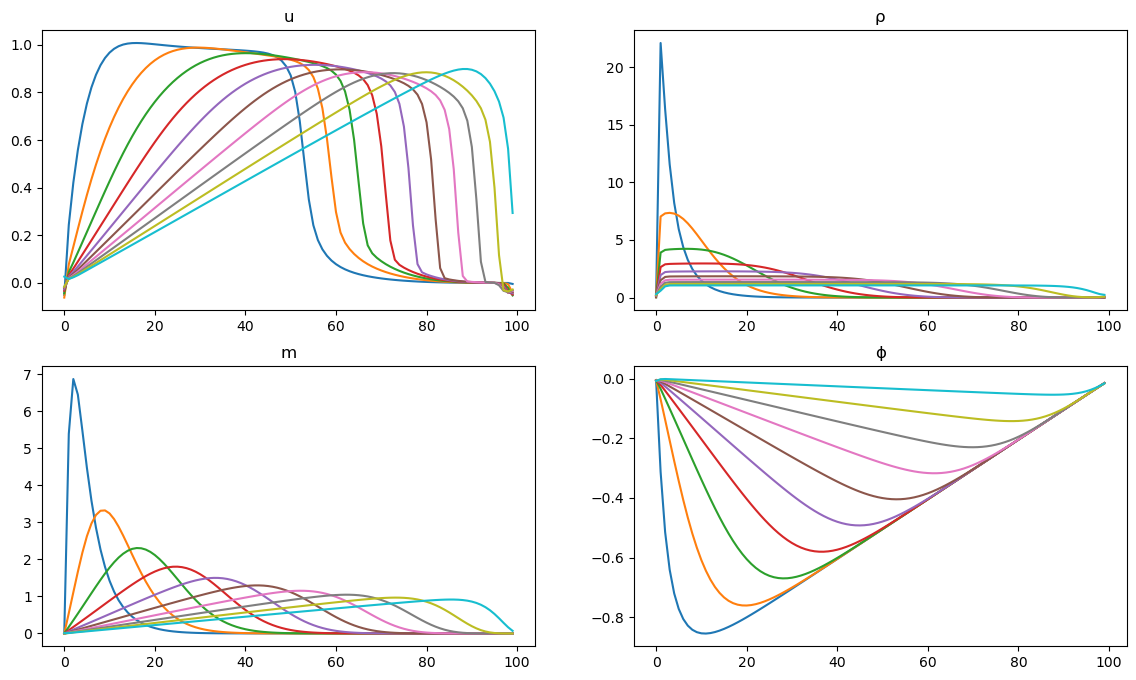

In [24]:
m0,m1,ρ,a0,a1 = mρa_from_ϕ(ϕ,dt,dx,ν)
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u=(m+a)/ρ
plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m"),(ϕ,"ϕ")]):
    plt.subplot(2,2,1+k); plt.title(name)
    for i in iT_plot: plt.plot(var[i])

### 3.2 Viscous

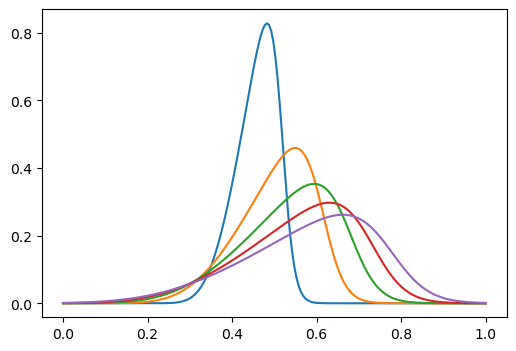

In [25]:
def νBurgers_exact(t,x,ν,Re):
    """
    Exact solution, viscous, quickly decreasing.
    Important : the factor sqrt(2) previously in Wikipedia was erroneous. (Now corrected.)
    """
    from scipy.special import erfc
    α = np.exp(Re)-1
    return np.sqrt(ν/(π*t)) * α *np.exp(-x**2/(4*ν*t)) /(1+α*erfc(x/np.sqrt(4*ν*t))/2)

ν = 1e-2 #5e-3; 
Re=5
X = np.linspace(0,1,200)
fig = plt.figure(figsize=[6,4])
for t in np.linspace(0.1,1,5):
    plt.plot(X,νBurgers_exact(t,X-0.4,ν,Re))
savefig(fig,"u.png")

In [26]:
nT = 50
t0 = 0.1 # Avoid the zero divide at the origin in Burgers_exact
t1 = 1
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
print(f"Times plotted : {np.array([T[i] for i in iT_plot])}")

nX = 100
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)
ϕ0 = np.zeros((nT,nX)) # Initial guess

Times plotted : [0.136 0.226 0.316 0.406 0.496 0.586 0.676 0.766 0.856 0.946]


In [27]:
%%time
u0 = νBurgers_exact(t0,X-0.4,ν,Re)
ϕ = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(dt,dx,u0,ν),step_min=1e-8,maxiter=200,verbosity=0).reshape(ϕ0.shape)

Initialization, objective 0.0
Convergence criterion satisfied, terminating.
Iteration 8, Newton step 1.0, objective -277.518219583251.
CPU times: user 554 ms, sys: 152 ms, total: 706 ms
Wall time: 733 ms


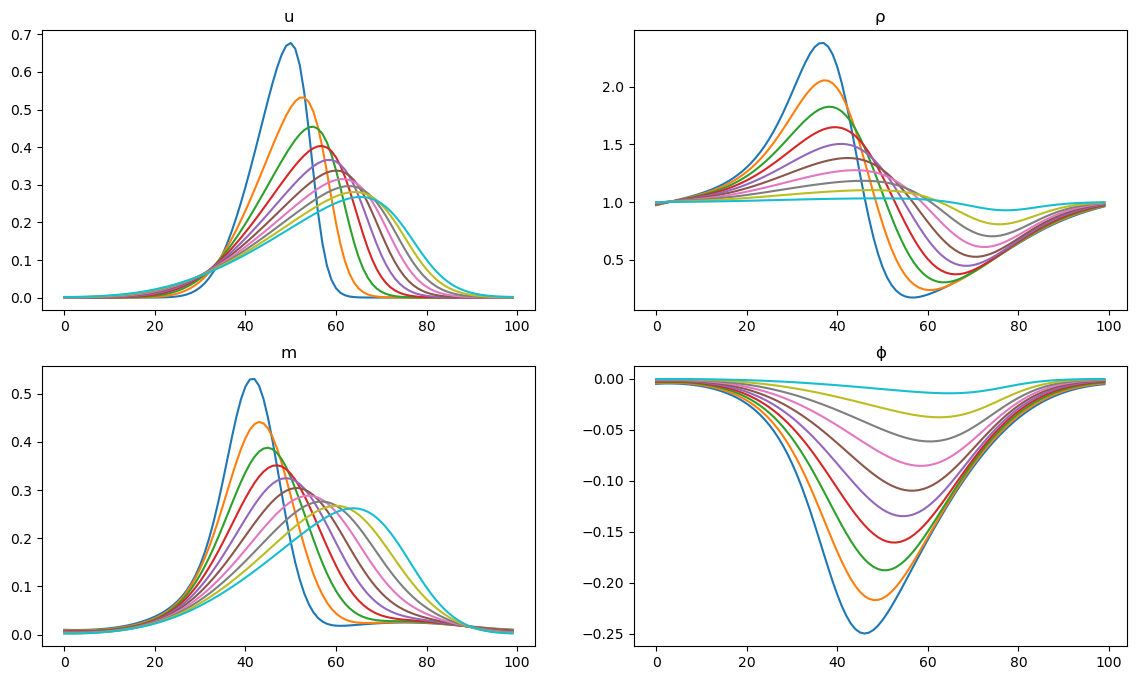

In [28]:
m0,m1,ρ,a0,a1 = mρa_from_ϕ(ϕ,dt,dx,ν)
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u=(m+a)/ρ
plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m"),(ϕ,"ϕ")]):
    plt.subplot(2,2,1+k); plt.title(name)
    for i in iT_plot: plt.plot(var[i])

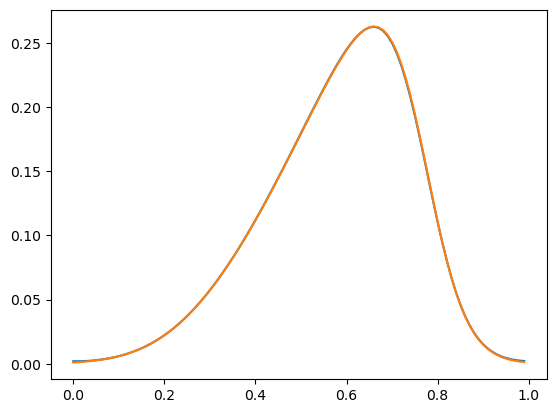

In [29]:
iT = nT-1
t = t0+(iT+0.5)*dt
plt.plot(X,u[iT])
plt.plot(X,νBurgers_exact(t,X-0.4,ν,Re))

### 3.3 Small viscosity, large time steps.

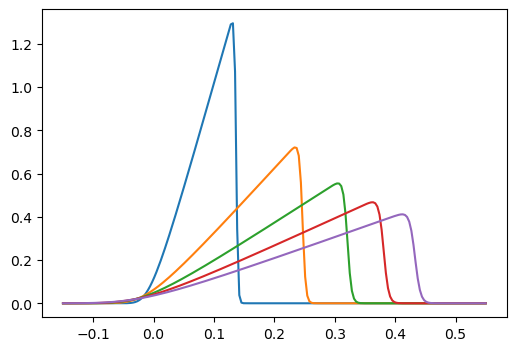

In [30]:
ν = 1e-3 #5e-3; 
Re=50
nX=200
X,dx = np.linspace(-0.15,0.55,nX,retstep=True)
fig = plt.figure(figsize=[6,4])
for t in np.linspace(0.1,1,5):
    plt.plot(X,νBurgers_exact(t,X,ν,Re))

t0 = 0.1 # Avoid the zero divide at the origin in Burgers_exact
t1 = 1

In [31]:
%%time
nT = 8
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
u0 = νBurgers_exact(t0,X,ν,Re)
ϕ0 = np.zeros((nT,nX)) # Initial guess
ϕ = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(dt,dx,u0,ν),step_min=1e-8,maxiter=200,verbosity=0).reshape(ϕ0.shape)

Initialization, objective 0.0


/var/folders/pr/ywmc0vdj1_q45y494__w0nsr0000gn/T/ipykernel_91766/314338759.py:28: RuntimeWarning: invalid value encountered in log
  return P(Dtϕ+ν*Dxxϕ[:-1],1-Dxϕ[:-1]) + P(Dtϕ+ν*Dxxϕ[1:],1-Dxϕ[1:]) - (ϵ * np.sum(np.log(1-Dxϕ)) if ϵ>0 else 0) + \


Convergence criterion satisfied, terminating.
Iteration 18, Newton step 1.0, objective -178.6681627160562.
CPU times: user 412 ms, sys: 111 ms, total: 523 ms
Wall time: 525 ms


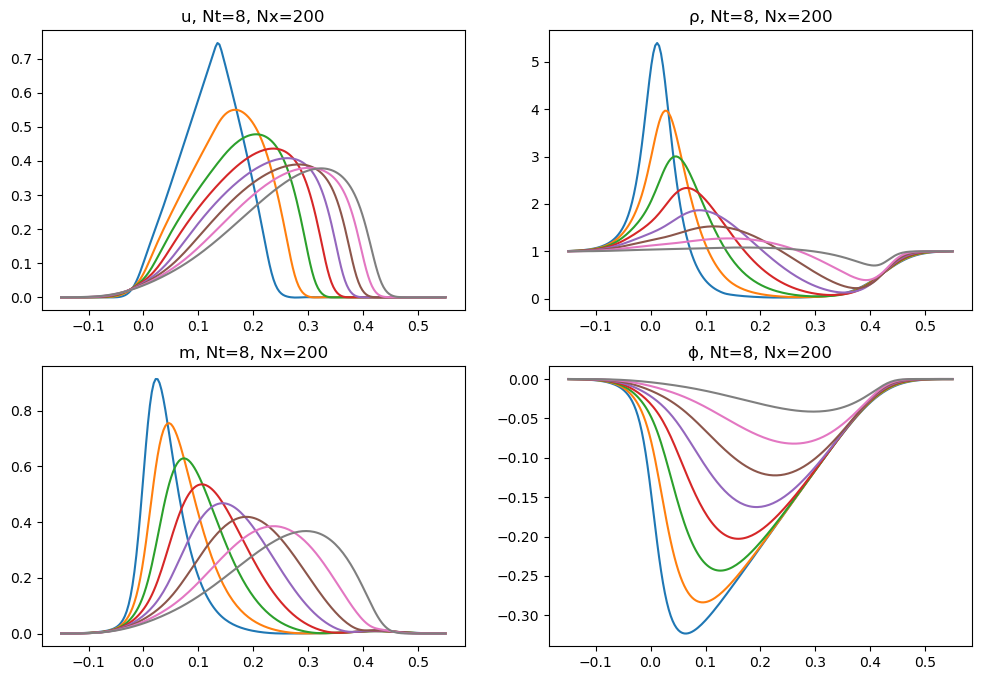

In [32]:
# Case ν=0. u takes negative values... Not very nice.
m0,m1,ρ,a0,a1 = mρa_from_ϕ(ϕ,dt,dx,ν)
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u=(m+a)/ρ
fig = plt.figure(figsize=[12,8])
for k,(var,name,aname) in enumerate([(u,"u","u"),(ρ,"ρ","rho"),(m,"m","m"),(ϕ,"ϕ","phi")]):
    ax = plt.subplot(2,2,1+k); plt.title(f"{name}, Nt={nT}, Nx={nX}")
    for i in range(nT): plt.plot(X,var[i])
    savefig(fig,f"Small_Nt_{aname}.png",ax=ax)

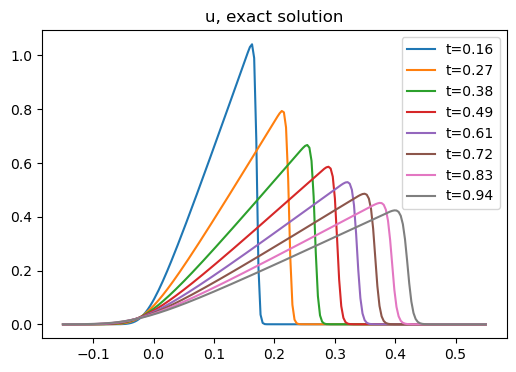

In [33]:
fig=plt.figure(figsize=[6,4])
plt.title("u, exact solution")
for iT in range(nT):
#    plt.plot(X,u[iT],color=f"C{iT}")
    t = t0+(iT+0.5)*dt
    plt.plot(X,νBurgers_exact(t,X,ν,Re),color=f"C{iT}",label=f"t={t:.2f}")
plt.legend()
savefig(fig,"Small_Nt_exact.png")

In [34]:
%%time
nT = 64
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)

u0 = νBurgers_exact(t0,X,ν,Re)
ϕ0 = np.zeros((nT,nX)) # Initial guess
ϕ = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(dt,dx,u0,ν),step_min=1e-8,maxiter=200,verbosity=0).reshape(ϕ0.shape)

Initialization, objective 0.0


/var/folders/pr/ywmc0vdj1_q45y494__w0nsr0000gn/T/ipykernel_91766/314338759.py:28: RuntimeWarning: invalid value encountered in log
  return P(Dtϕ+ν*Dxxϕ[:-1],1-Dxϕ[:-1]) + P(Dtϕ+ν*Dxxϕ[1:],1-Dxϕ[1:]) - (ϵ * np.sum(np.log(1-Dxϕ)) if ϵ>0 else 0) + \


Convergence criterion satisfied, terminating.
Iteration 24, Newton step 1.0, objective -1524.1114527083935.
CPU times: user 8.43 s, sys: 1.63 s, total: 10.1 s
Wall time: 10.2 s


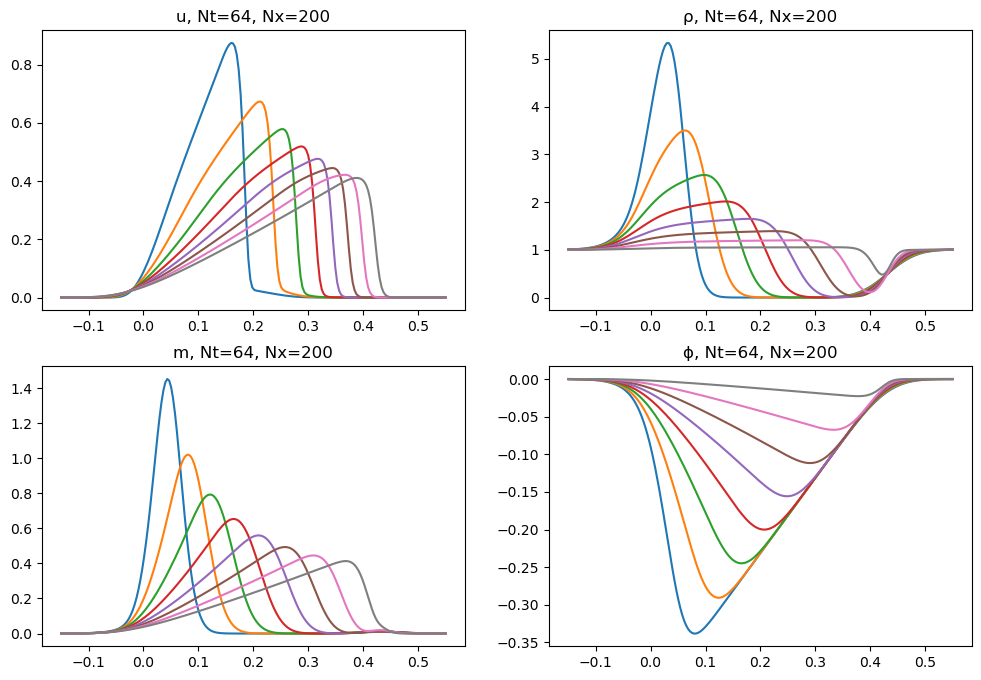

In [35]:
m0,m1,ρ,a0,a1 = mρa_from_ϕ(ϕ,dt,dx,ν)
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u=(m+a)/ρ
fig = plt.figure(figsize=[12,8])
for k,(var,name,aname) in enumerate([(u,"u","u"),(ρ,"ρ","rho"),(m,"m","m"),(ϕ,"ϕ","phi")]):
    ax = plt.subplot(2,2,1+k); plt.title(f"{name}, Nt={nT}, Nx={nX}")
    for i in range(4,nT,8): plt.plot(X,var[i])
    savefig(fig,f"Large_Nt_{aname}.png",ax=ax)

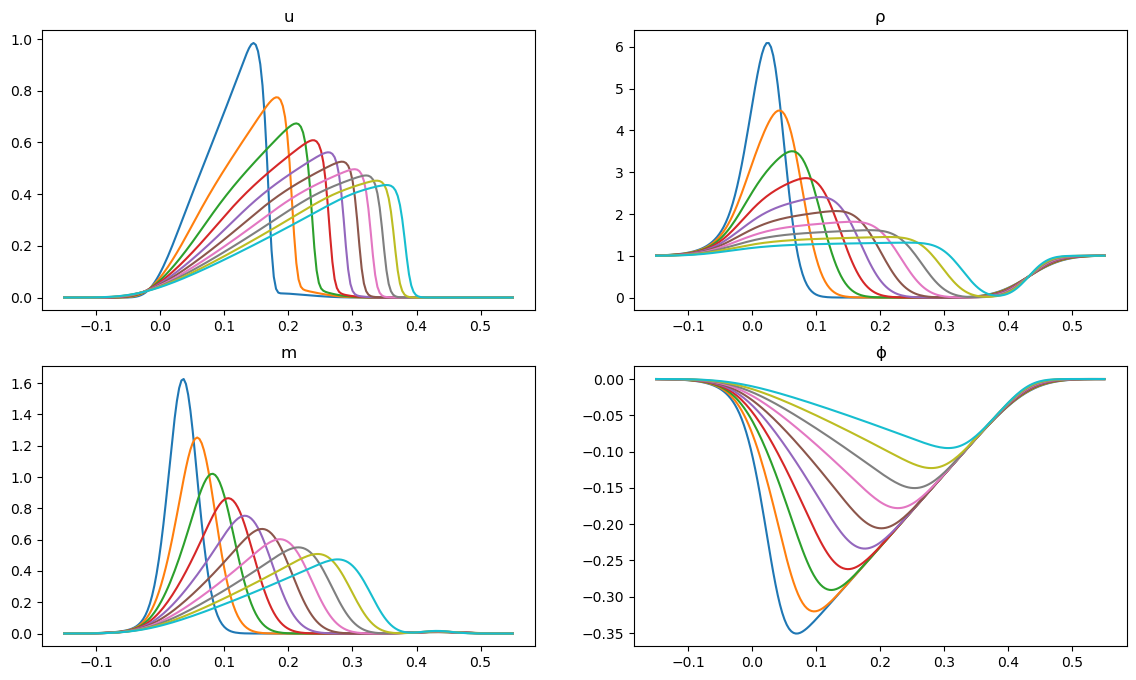

In [36]:
# Case ν=0. u takes negative values... Not very nice.
m0,m1,ρ,a0,a1 = mρa_from_ϕ(ϕ,dt,dx,ν)
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u=(m+a)/ρ
plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ,"ρ"),(m,"m"),(ϕ,"ϕ")]):
    plt.subplot(2,2,1+k); plt.title(name)
    for i in iT_plot: plt.plot(X,var[i])

## 4. Running the Primal-Dual optimizer

### 4.1 Non-viscous

In [37]:
def run_CP(u0,dt,dx,nT,τ_f=1,verb=0,maxiter=1000):
    # Normalization of the initial condition
    xp = Misc.get_array_module(u0)
    if xp is not np: u0_xp=u0; u0=u0.cpu().numpy() # Only for some cheap preprocessing...
    np_float_t = Misc.convert_dtype['np'][u0.dtype]
    Nu0 = np.sqrt(np.sum(u0**2)/np_float_t(u0.size)) # Averaged L2 norm of u0
    u0 = u0/Nu0
    dt = dt*Nu0
    rhs = np.zeros((nT+1,nX))
    Rhs = Prox.mk_rhs(dt,u0,rhs)
    dt,dx,τ_f,Nu0 = map(np_float_t,(dt,dx,τ_f,Nu0))

    # Initialization
    ρ = np.ones_like(u0,shape=(2*nT,*u0.shape))
    m0 = np.asarray([*(u0,)*nT,*(-u0,)*nT])
    m1 = m0.copy()
    if xp is not np: 
        m0,m1,ρ,Rhs = [Misc.asarray(e,like=u0_xp,dtype=u0_xp.dtype) for e in (m0,m1,ρ,Rhs)]
    x = Misc.asobjarray(m0,m1,ρ) 
    y = 0*x # Dual variable
    tx = deepcopy(x)

    # Proximal operators and time steps
    prox_f = Misc.useobjarray(mk_prox_Burgers(Rhs))
    prox_g = Misc.useobjarray(mk_proj_Burgers(dt,dx,ρ))
    def prox_gs(y,τ=1): return y-prox_g(y,inplace=False) # Projection onto orthogonal space
    τ_gs = 1/τ_f # One needs τ_f τ_gs |K|^2 <1, but the coupling operator is the identity
    x,y,tx = Misc.ChambollePock_raw(x,y,tx,prox_f,prox_gs,τ_f,τ_gs,maxiter)
    return x[0]*Nu0,x[1]*Nu0,x[2] # Put back the normalization

In [38]:
nT = 50
t0 = 1e-5 # Avoid the zero divide at the origin
t1 = 1
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
print(f"Times plotted : {np.array([T[i] for i in iT_plot])}")

nX = 100
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)

Times plotted : [0.0400096 0.1400086 0.2400076 0.3400066 0.4400056 0.5400046 0.6400036
 0.7400026 0.8400016 0.9400006]


In [39]:
%%time
#u0=1-X
u0 = Burgers_exact(t0,X)
m0_ti,m1_ti,ρ_ti_ = run_CP(u0,dt,dx,nT,τ_f=1,maxiter=2000)
m_ti,ρ_ti = deduplicate(m0_ti,m1_ti,ρ_ti_)
u = m_ti/ρ_ti
#u[ρ_ti<1e-2]=0

CPU times: user 2.78 s, sys: 1.4 s, total: 4.18 s
Wall time: 2.71 s


/var/folders/pr/ywmc0vdj1_q45y494__w0nsr0000gn/T/ipykernel_91766/314338759.py:43: RuntimeWarning: divide by zero encountered in divide
  iρ = (1/ρ[:nT]+1/ρ[nT:][::-1])/2 # Symmetry
<timed exec>:5: RuntimeWarning: divide by zero encountered in divide
<timed exec>:5: RuntimeWarning: invalid value encountered in divide


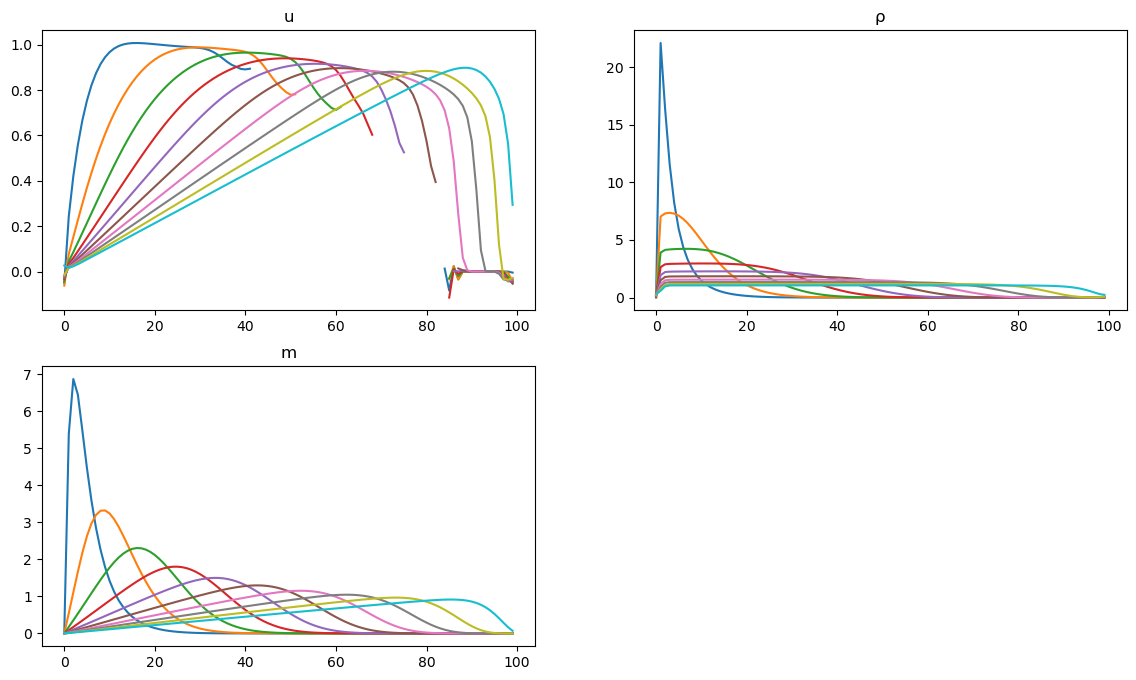

In [40]:
plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ_ti,"ρ"),(m_ti,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    plt.subplot(2,2,1+k); plt.title(name)
    for i in iT_plot: plt.plot(var[i])

Another test case...

CPU times: user 6.83 s, sys: 1.89 s, total: 8.72 s
Wall time: 5.46 s


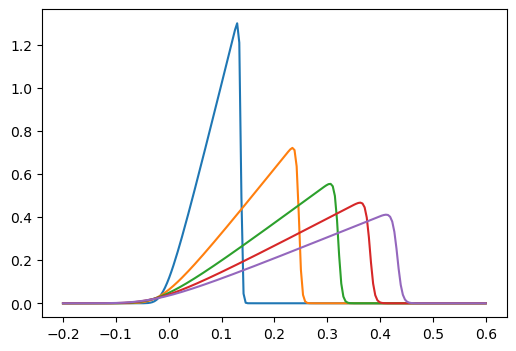

In [41]:
%%time
ν = 1e-3 
Re=50
nX=200
X,dx = np.linspace(-0.2,0.6,nX,retstep=True)
fig = plt.figure(figsize=[6,4])
for t in np.linspace(0.1,1,5):
    plt.plot(X,νBurgers_exact(t,X,ν,Re))

nT = 10
t0 = 0.1 # Avoid the zero divide at the origin in Burgers_exact
t1 = 1
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = range(len(T)) #[i for i in range(len(T)) if i%5==2] # Plot only a portion of the times


u0 = νBurgers_exact(t0,X,ν,Re)
m0_ti,m1_ti,ρ_ti_ = run_CP(u0,dt,dx,nT,τ_f=1,maxiter=10000)
m_ti,ρ_ti = deduplicate(m0_ti,m1_ti,ρ_ti_)
u = m_ti/ρ_ti

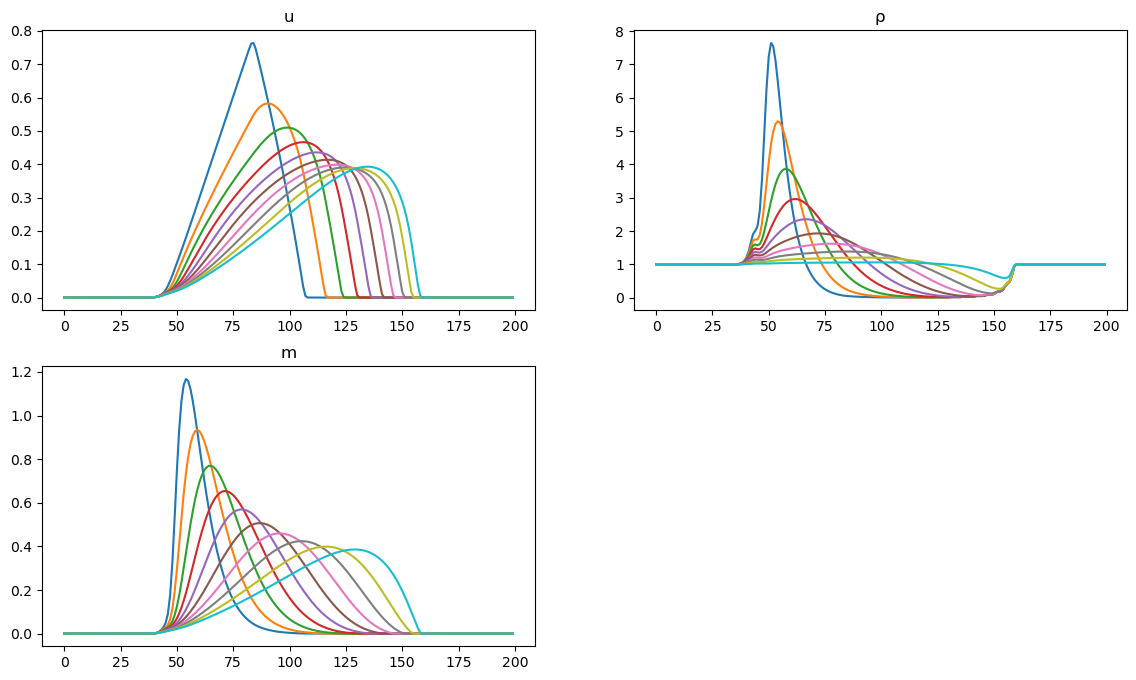

In [42]:
plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ_ti,"ρ"),(m_ti,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    plt.subplot(2,2,1+k); plt.title(name)
    for i in iT_plot: plt.plot(var[i])

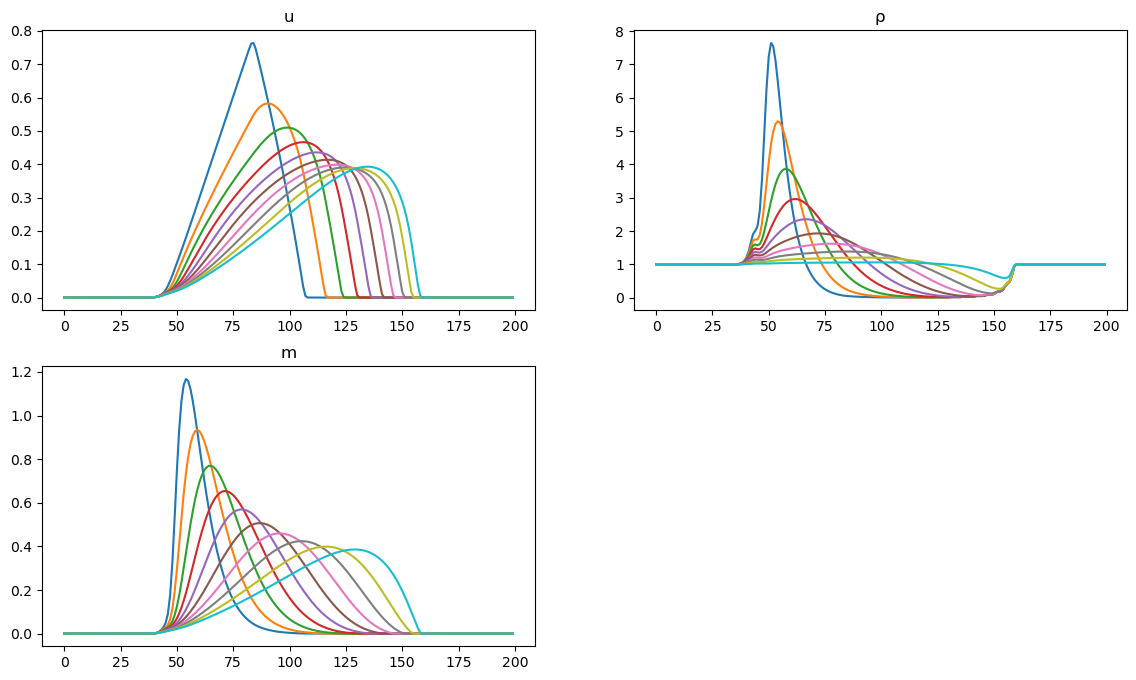

In [43]:
# ν=0, nT=50, The final times are not so bad (better than the Newton method ??), but the initial times are terrible. 
plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ_ti,"ρ"),(m_ti,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    plt.subplot(2,2,1+k); plt.title(name)
    for i in iT_plot: plt.plot(var[i])

### 4.2 Viscous

In [44]:
def run_CP_ν(u0,ν,dt,dx,nT,τ_f=1,verb=0,maxiter=1000):
    # Normalization of the initial condition
    xp = Misc.get_array_module(u0)
    if xp is not np: u0_xp=u0; u0=u0.cpu().numpy() # Only for some cheap preprocessing...
    np_float_t = Misc.convert_dtype['np'][u0.dtype]
    Nu0 = np.sqrt(np.sum(u0**2)/np_float_t(u0.size)) # Averaged L2 norm of u0
#    Nu0 = 1 # Avoid the time rescaling by setting Nu0=1
    u0 = u0/Nu0
    dt = dt*Nu0
    ν = ν/Nu0
    rhs = np.zeros((nT+1,nX))
    Rhs = Prox.mk_rhs(dt,u0,rhs)
    dt,dx,τ_f,Nu0 = map(np_float_t,(dt,dx,τ_f,Nu0))

    # Initialization
    ρ = np.ones_like(u0,shape=(2*nT,*u0.shape))
    m0 = np.asarray([*(u0,)*nT,*(-u0,)*nT])
    m1 = m0.copy()
    a0 = np.zeros_like(ρ)
    a1 = a0.copy()
    if xp is not np: 
        m0,m1,ρ,a0,a1,Rhs = [Misc.asarray(e,like=u0_xp,dtype=u0_xp.dtype) for e in (m0,m1,ρ,a0,a1,Rhs)]
    x = Misc.asobjarray(m0,m1,ρ,a0,a1) 
    y = 0*x # Dual variable
    tx = deepcopy(x)

    # Proximal operators and time steps
    prox_f = Misc.useobjarray(mk_prox_Burgers(Rhs,ν))
    prox_g = Misc.useobjarray(mk_proj_Burgers(dt,dx,ρ,ν))
    def prox_gs(y,τ=1): return y-prox_g(y,inplace=False) # Projection onto orthogonal space
    τ_gs = 1./τ_f # One needs τ_f τ_gs |K|^2 <1, but the coupling operator is the identity
    x,y,tx = Misc.ChambollePock_raw(x,y,tx,prox_f,prox_gs,τ_f,τ_gs,maxiter)
    return x[0]*Nu0,x[1]*Nu0,x[2],x[3]*Nu0,x[4]*Nu0 # Put back the normalization

In [45]:
nT = 50
t0 = 0.1 # Avoid the zero divide at the origin in Burgers_exact
t1 = 1
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
print(f"Times plotted : {np.array([T[i] for i in iT_plot])}")

nX = 100
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)

Times plotted : [0.136 0.226 0.316 0.406 0.496 0.586 0.676 0.766 0.856 0.946]


In [46]:
%%time
ν = 1e-2 
Re=5
u0 = νBurgers_exact(t0,X-0.4,ν,Re)
m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti = run_CP_ν(u0,ν,dt,dx,nT,τ_f=1,maxiter=2000)
m_ti,ρ_ti,a_ti = deduplicate(m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti)
u = (m_ti+a_ti)/ρ_ti
#u[ρ_ti<1e-2]=0

CPU times: user 3.77 s, sys: 1.93 s, total: 5.7 s
Wall time: 3.79 s


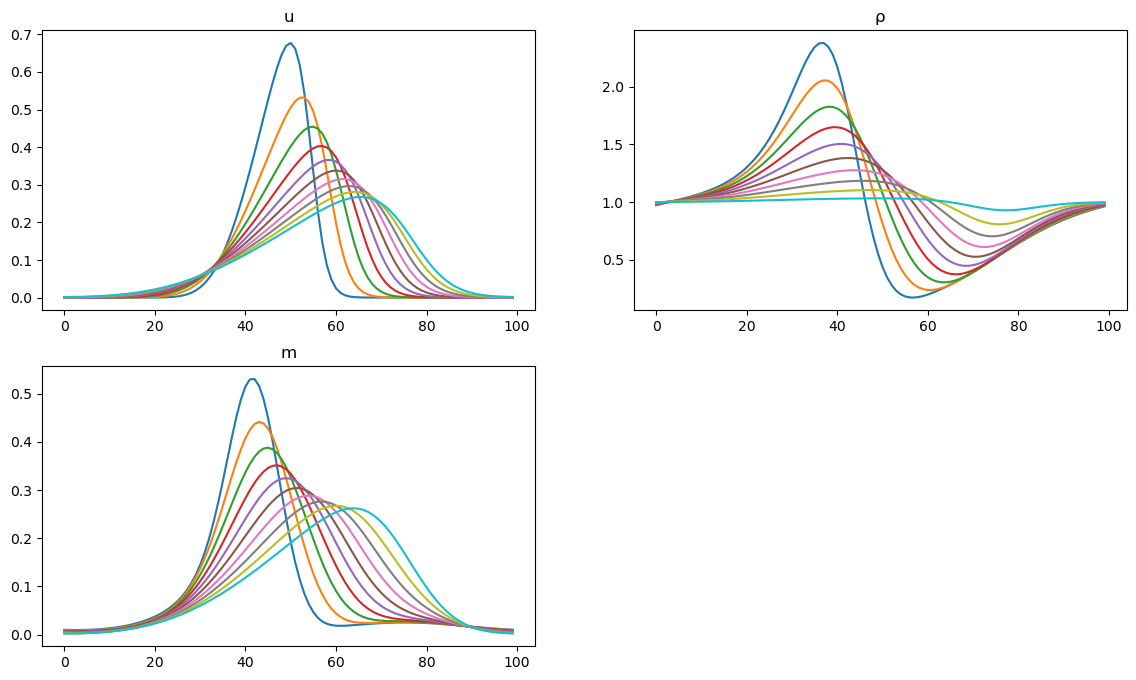

In [47]:
plt.figure(figsize=[14,8])
for k,(var,name) in enumerate([(u,"u"),(ρ_ti,"ρ"),(m_ti,"m")]): # Note : ϕ is not reconstructed by the primal dual method
    plt.subplot(2,2,1+k); plt.title(name)
    for i in iT_plot: plt.plot(var[i])

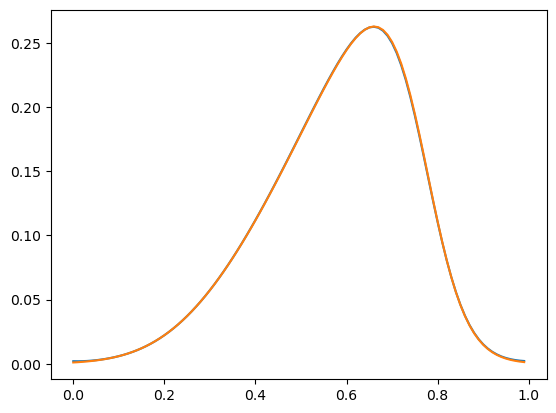

In [48]:
iT = nT-1
t = t0+(iT+0.5)*dt
plt.plot(X,u[iT])
plt.plot(X,νBurgers_exact(t,X-0.4,ν,Re));

## 5 Running on the GPU

Notes: 
- no improvement (and possibly some degradation) is expected if the test case is too small.
- the M1 GPU is disappointing (almost no improvement w.r.t CPU)
- works well on Nvidia GPUs
- another notebook is specifically devoted to GPU experiments

In [49]:
import torch

**No viscosity**

In [50]:
%%time
nT = 50
t0 = 1e-5 # Avoid the zero divide at the origin
t1 = 1
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
nX = 100
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)
u0 = Burgers_exact(t0,X)

# Initialize taichi, transfer array to GPU, and run
ti.init(arch=ti.gpu,default_fp=ti.f32)
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)
m0_ti,m1_ti,ρ_ti_ = run_CP(u0_gpu,dt,dx,nT,τ_f=1,maxiter=2000)

[Taichi] Starting on arch=metal
CPU times: user 4.89 s, sys: 3.19 s, total: 8.08 s
Wall time: 14.5 s


**With viscosity.**

In [51]:
%%time
nT = 50
t0 = 0.1 # Avoid the zero divide at the origin in Burgers_exact
t1 = 1
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
nX = 100
X,dx = np.linspace(0,1,nX,endpoint=False,retstep=True)
ν = 1e-2 
Re=5
u0 = νBurgers_exact(t0,X-0.4,ν,Re)

# Initialize taichi, transfer array to GPU, and run
ti.init(arch=ti.gpu,default_fp=ti.f32)
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)
m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti = run_CP_ν(u0_gpu,ν,dt,dx,nT,τ_f=1,maxiter=2000)

[Taichi] Starting on arch=metal
CPU times: user 7.61 s, sys: 4.39 s, total: 12 s
Wall time: 20.1 s


In [52]:
%%time
ti.init(arch=ti.cpu,default_fp=ti.f64)
m0_ti,m1_ti,ρ_ti_,a0_ti,a1_ti = run_CP_ν(u0,ν,dt,dx,nT,τ_f=1,maxiter=2000)

[Taichi] Starting on arch=arm64
CPU times: user 3.76 s, sys: 1.11 s, total: 4.88 s
Wall time: 2.67 s


**Restore CPU mode**

In [53]:
ti.init(arch=ti.cpu,default_fp=ti.f64)

[Taichi] Starting on arch=arm64


## 6. Convergence rate visualization

We use a Newton method, and check convergence rate

Times plotted : [0.136 0.226 0.316 0.406 0.496 0.586 0.676 0.766 0.856 0.946]
Initialization, objective 0.0
Convergence criterion satisfied, terminating.
Iteration 8, Newton step 1.0, objective -370.1889751413015.


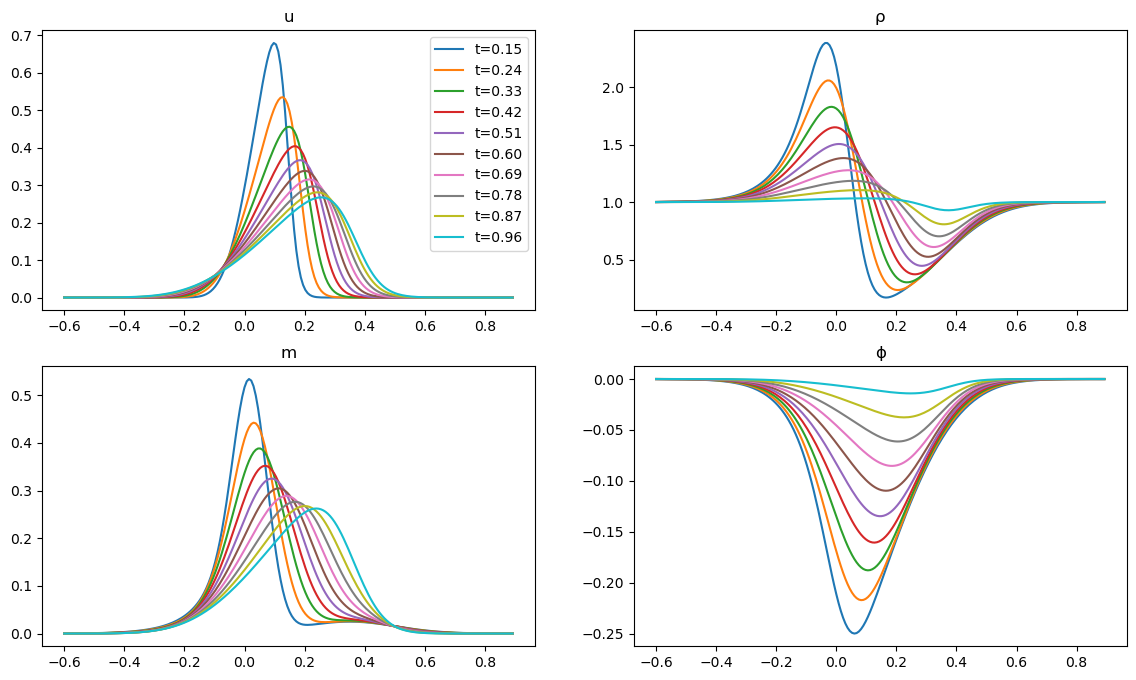

In [54]:
ν=1e-2
Re=5
nT = 50
t0 = 0.1 # Avoid the zero divide at the origin in Burgers_exact
t1 = 1
T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
iT_plot = [i for i in range(len(T)) if i%5==2] # Plot only a portion of the times
print(f"Times plotted : {np.array([T[i] for i in iT_plot])}")

nX = 200
X,dx = np.linspace(-0.6,0.9,nX,endpoint=False,retstep=True)
ϕ0 = np.zeros((nT,nX)) # Initial guess

u0 = νBurgers_exact(t0,X,ν,Re)
ϕ = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(dt,dx,u0,ν),step_min=1e-8,maxiter=200,verbosity=0).reshape(ϕ0.shape)


m0,m1,ρ,a0,a1 = mρa_from_ϕ(ϕ,dt,dx,ν)
m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
u=(m+a)/ρ
fig = plt.figure(figsize=[14,8])
for k,(var,name,aname) in enumerate([(u,"u","u"),(ρ,"ρ","rho"),(m,"m","m"),(ϕ,"ϕ","phi")]):
    ax = plt.subplot(2,2,1+k); plt.title(name)
    for i in iT_plot: plt.plot(X,var[i],label=f"t={t0+(i+0.5)*dt:.2f}")
    if aname=="u": plt.legend()
    savefig(fig,f"{aname}.png",ax=ax)

### 5.1 Choice of time step

In [55]:
def mixednorm(arr,p,q): return norm(norm(arr,q,axis=1,averaged=True),p,averaged=True)

ν=1e-2
t0 = 0.1
t1 = 1; T = t1-t0
nX = 256
nTs = np.geomspace(4,nX,10).astype(int) 

X,dx = np.linspace(-0.6,0.9,nX,retstep=True,endpoint=False)

if False:
    errors_timestepchoice = []
    for nT in nTs:
        T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
        Tp = T+dt/2
    
        print(f"\n ----- {nT=}, {nX=} ------")
        u0 = νBurgers_exact(t0,X,ν,Re)
        ϕ0 = np.zeros((nT,nX))
        ϕ = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(dt,dx,u0,ν),step_min=1e-8,maxiter=200).reshape(ϕ0.shape)
        m0,m1,ρ,a0,a1 = mρa_from_ϕ(ϕ,dt,dx,ν)
        m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
        uh=(m+a)/ρ
    
        ue = np.array([νBurgers_exact(t,X,ν,Re) for t in Tp]) # exact Barenblatt profile
        err = uh-ue
        errors_timestepchoice.append( [mixednorm(err,np.inf,1), norm(err,1,averaged=True), norm(err,2,averaged=True), norm(err,np.inf,averaged=True)])
        # Compute the L2, Linf x L1, and some other errors...
    errors_timestepchoice = np.array(errors_timestepchoice)
else:
    errors_timestepchoice = np.array([[0.00813688, 0.00624678, 0.0146172 , 0.08048401],
       [0.0063851 , 0.00394791, 0.01009287, 0.08052367],
       [0.00449521, 0.00202342, 0.00594781, 0.06972067],
       [0.00298959, 0.00101908, 0.00338948, 0.05258165],
       [0.00182622, 0.00052099, 0.00185787, 0.03538927],
       [0.00097206, 0.00027381, 0.00096334, 0.0204805 ],
       [0.00048494, 0.00017382, 0.00055663, 0.01087656],
       [0.00025953, 0.00013319, 0.00038849, 0.00525415],
       [0.00022216, 0.00011811, 0.00033077, 0.00347313],
       [0.00020844, 0.00011239, 0.00031078, 0.00330001]])

Similarly to the QPME test case, $N_x = 5 N_t$ seems to be a reasonnable choice.
However, the CFL is here much less constraining.


In [56]:
for i in (4,5,6):
    print(errors_timestepchoice[i]/errors_timestepchoice[-1],nX/nTs[i])

[ 8.76137018  4.63555476  5.97808739 10.72398872] 10.24
[4.66350029 2.43624878 3.09974902 6.20619331] 6.4
[2.32652082 1.54657888 1.79107407 3.29591729] 4.063492063492063


### 5.2 Convergence rate

In [57]:
ν=1e-2
t0 = 0.1
t1 = 1; T = t1-t0
nTs = np.geomspace(4,400,14).astype(int) 

if False:
    errors = []
    for nT in nTs:
        T,dt = np.linspace(t0,t1,nT,endpoint=False,retstep=True)
        Tp = T+dt/2

        nX = 5*nT
        X,dx = np.linspace(-0.6,0.9,nX,retstep=True,endpoint=False)

        print(f"\n ----- {nT=}, {nX=} ------")
        u0 = νBurgers_exact(t0,X,ν,Re)
        ϕ0 = np.zeros((nT,nX))
        ϕ = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(dt,dx,u0,ν),step_min=1e-8,maxiter=200).reshape(ϕ0.shape)
        m0,m1,ρ,a0,a1 = mρa_from_ϕ(ϕ,dt,dx,ν)
        m,ρ,a = deduplicate(m0,m1,ρ,a0,a1)
        uh=(m+a)/ρ
    
        ue = np.array([νBurgers_exact(t,X,ν,Re) for t in Tp]) # exact Barenblatt profile
        err = uh-ue
        errors.append( [mixednorm(err,np.inf,1), norm(err,1,averaged=True), norm(err,2,averaged=True), norm(err,np.inf,averaged=True)])
        # Compute the L2, Linf x L1, and some other errors...
    errors = np.array(errors)
else:
    errors = np.array([[1.58758281e-02, 1.20071072e-02, 2.73838886e-02, 1.54743292e-01],
       [1.18709478e-02, 8.43576017e-03, 2.00298557e-02, 1.30765204e-01],
       [7.18261929e-03, 4.76930254e-03, 1.18728854e-02, 8.70953434e-02],
       [5.34280855e-03, 3.04302392e-03, 8.13639597e-03, 7.49804632e-02],
       [3.68547727e-03, 1.71990311e-03, 4.89246810e-03, 5.71834802e-02],
       [2.26687718e-03, 9.22375108e-04, 2.81864895e-03, 4.19086048e-02],
       [1.34436807e-03, 4.79811423e-04, 1.54449631e-03, 2.73909951e-02],
       [7.74606478e-04, 2.45969721e-04, 8.21223830e-04, 1.66517920e-02],
       [4.13163511e-04, 1.20186722e-04, 4.11025697e-04, 9.41817662e-03],
       [2.22677418e-04, 6.10273993e-05, 2.11294442e-04, 5.25560935e-03],
       [1.13432587e-04, 2.97725682e-05, 1.03705258e-04, 2.75009465e-03],
       [5.81525502e-05, 1.48699422e-05, 5.18254492e-05, 1.43789278e-03],
       [2.91667058e-05, 7.36937097e-06, 2.55579045e-05, 7.31217339e-04],
       [1.45191032e-05, 3.69105876e-06, 1.26242571e-05, 3.67672964e-04]])

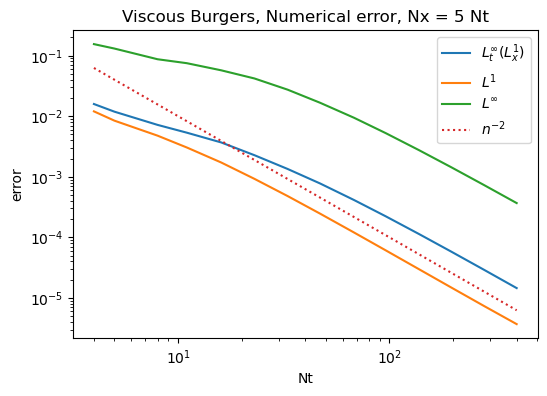

In [58]:
fig = plt.figure(figsize=[6,4])
plt.title("Viscous Burgers, Numerical error, Nx = 5 Nt")
plt.loglog(nTs,errors[:,0],label=r"$L_t^\infty (L_x^1)$")
plt.loglog(nTs,errors[:,1],label=r"$L^1$")
#plt.loglog(nTs,errors[:,2],label=r"$L^2$")
plt.loglog(nTs,errors[:,3],label=r"$L^\infty$")
plt.loglog(nTs,nTs**-2.,ls=':',label=r"$n^{-2}$")
#plt.loglog(nTs,2*nTs**-1.,ls=':',label=r"$n^{-1}$")
plt.xlabel('Nt'); plt.ylabel('error')
plt.legend();
savefig(fig,"Convergence.png")